# <b><span style='color:#F1A424'>AutoML - Regression - Medical Insurance Charges Prediction</span> </b>

### Disclaimer
The sample code (“Sample Code”) provided is not covered by any Teradata agreements. Please be aware that Teradata has no control over the model responses to such sample code and such response may vary. The use of the model by Teradata is strictly for demonstration purposes and does not constitute any form of certification or endorsement. The sample code is provided “AS IS” and any express or implied warranties, including the implied warranties of merchantability and fitness for a particular purpose, are disclaimed. In no event shall Teradata be liable for any direct, indirect, incidental, special, exemplary, or consequential damages (including, but not limited to, procurement of substitute goods or services; loss of use, data, or profits; or business interruption) sustained by you or a third party, however caused and on any theory of liability, whether in contract, strict liability, or tort arising in any way out of the use of this sample code, even if advised of the possibility of such damage.

## <b> Problem overview:</b>
    

**Dataset Used : Medical insurance Dataset**

**Features**:

- `Age`: The insured person's age.
- `Sex`: Gender (male or female) of the insured.
- `BMI (Body Mass Index)`: A measure of body fat based on height and weight.
- `Children`: The number of dependents covered.
- `Smoker`: Whether the insured is a smoker (yes or no).
- `Region`: The geographic area of coverage.

**Target Variable**:

- `Charges`: The medical insurance costs incurred by the insured person.
    
**Objective**:

The primary objective is typically to build a model that can accurately predict medical insurance costs incurred by the insured person.

**Usecase**:

Here, we will use AutoML(Automated Machine Learning) functionality to automate the entire process of developing a predictive model. It will perform feature exploration, feature engineering, data preparation, model training and evaluation on dataset in auto run and at end we will get leaderboard containined different models along with their performance. Model will also have rank associated with them which indicates which is best performing model for given data followed by other models.

In [1]:
# Importing AutoML from teradataml
from teradataml import AutoML, AutoRegressor

In [2]:
# Importing other important libraries
import getpass
from teradataml import create_context, remove_context
from teradataml import DataFrame
from teradataml import load_example_data
from teradataml import TrainTestSplit

In [3]:
# Create the connection.
host = getpass.getpass("Host: ")
username = getpass.getpass("Username: ")
password = getpass.getpass("Password: ")

con = create_context(host=host, username=username, password=password)

Host:  ········
Username:  ········
Password:  ········


## <b><span style='color:#F1A424'>| 1.</span> Loading Dataset </b>

In [4]:
# Loading dataset from example data collection
load_example_data('teradataml','insurance')

In [5]:
# Fetching in teradata dataframe
insurance_df = DataFrame("insurance")

In [6]:
# first 5 rows
insurance_df.head()

age,sex,bmi,children,smoker,region,charges
18,male,53.13,0,no,southeast,1163.4627
18,female,31.13,0,no,southeast,1621.8827
18,female,40.26,0,no,southeast,1634.5734
18,male,17.29,2,yes,northeast,12829.4551
18,male,43.01,0,no,southeast,1149.3959
18,female,29.165,0,no,northeast,7323.734819
18,male,23.21,0,no,southeast,1121.8739
18,female,25.08,0,no,northeast,2196.4732
18,female,36.85,0,yes,southeast,36149.4835
18,female,20.79,0,no,southeast,1607.5101


In [7]:
# insurance_df dataset
insurance_df.shape

(1338, 7)

In [8]:
# Performing sampling to get 80% for trainning and 20% for testing
insurance_df_sample = insurance_df.sample(frac = [0.8, 0.2])

In [9]:
insurance_df_sample.head()

age,sex,bmi,children,smoker,region,charges,sampleid
18,male,17.29,2,yes,northeast,12829.4551,1
18,male,41.14,0,no,southeast,1146.7966,1
18,female,42.24,0,yes,southeast,38792.6856,1
18,female,29.165,0,no,northeast,7323.734819,2
18,female,36.85,0,yes,southeast,36149.4835,1
18,male,34.1,0,no,southeast,1137.011,2
18,female,33.88,0,no,southeast,11482.63485,1
18,female,26.315,0,no,northeast,2198.18985,2
18,female,31.35,0,no,southeast,1622.1885,2
18,female,31.13,0,no,southeast,1621.8827,1


In [10]:
# Fetching train and test data
insurance_df_train= insurance_df_sample[insurance_df_sample['sampleid'] == 1].drop('sampleid', axis=1)
insurance_df_test = insurance_df_sample[insurance_df_sample['sampleid'] == 2].drop('sampleid', axis=1)

In [11]:
# train data shape
insurance_df_train.shape

(1070, 7)

In [12]:
# test data shape
insurance_df_test.shape

(268, 7)

In [13]:
#train dataset
insurance_df_train.head()

age,sex,bmi,children,smoker,region,charges
18,female,32.12,2,no,southeast,2801.2588
18,female,36.85,0,no,southeast,1629.8335
18,female,39.16,0,no,southeast,1633.0444
18,male,21.47,0,no,northeast,1702.4553
18,female,40.185,0,no,northeast,2217.46915
18,female,40.28,0,no,northeast,2217.6012
18,male,35.2,1,no,southeast,1727.54
18,male,30.14,0,no,southeast,1131.5066
18,female,31.92,0,no,northeast,2205.9808
18,female,31.35,4,no,northeast,4561.1885


In [14]:
# test dataset
insurance_df_test.head()

age,sex,bmi,children,smoker,region,charges
18,female,29.165,0,no,northeast,7323.734819
18,female,38.28,0,no,southeast,1631.8212
18,female,31.35,0,no,southeast,1622.1885
18,female,26.315,0,no,northeast,2198.18985
18,male,26.125,0,no,northeast,1708.92575
18,male,33.535,0,yes,northeast,34617.84065
18,male,26.18,2,no,southeast,2304.0022
18,female,26.73,0,no,southeast,1615.7667
18,male,34.1,0,no,southeast,1137.011
18,male,33.66,0,no,southeast,1136.3994


## <b><span style='color:#F1A424'>| 2.</span> Fitting AutoML </b>

In [15]:
# Creating AutoRegressor instance
# Using all models from model training.
# Keeping early stopping timer threshold to 200 sec
# and verbose level 2 for detailed loggging
# Using volatile=True to create all intermediate tables as volatile tables.

aml = AutoRegressor(max_runtime_secs=200,
                    verbose=2,
                    volatile=True)

Feature Exploration started ...

Data Overview:
Total Rows in the data: 1070
Total Columns in the data: 7

Column Summary:


ColumnName,Datatype,NonNullCount,NullCount,BlankCount,ZeroCount,PositiveCount,NegativeCount,NullPercentage,NonNullPercentage
sex,VARCHAR(20) CHARACTER SET LATIN,1070,0,0,None,None,None,0.0,100.0
region,VARCHAR(20) CHARACTER SET LATIN,1070,0,0,None,None,None,0.0,100.0
smoker,VARCHAR(20) CHARACTER SET LATIN,1070,0,0,None,None,None,0.0,100.0
children,INTEGER,1070,0,None,453,617,0,0.0,100.0
bmi,FLOAT,1070,0,None,0,1070,0,0.0,100.0
age,INTEGER,1070,0,None,0,1070,0,0.0,100.0
charges,FLOAT,1070,0,None,0,1070,0,0.0,100.0


            age       bmi  children    charges
func                                          
min      18.000    15.960     0.000   1121.874
std      13.950     6.195     1.198  11967.243
25%      27.000    26.296     0.000   4803.719
50%      40.000    30.495     1.000   9502.442
75%      51.000    34.893     2.000  16547.262
max      64.000    53.130     5.000  63770.428
mean     39.315    30.768     1.099  13219.012
count  1070.000  1070.000  1070.000   1070.000

Statistics of Data:


func,age,bmi,children,charges
50%,40,30.495,1,9502.442
count,1070,1070,1070,1070
mean,39.315,30.768,1.099,13219.012
min,18,15.96,0,1121.874
max,64,53.13,5,63770.428
75%,51,34.893,2,16547.262
25%,27,26.296,0,4803.719
std,13.95,6.195,1.198,11967.243



Categorical Columns with their Distinct values:
ColumnName                DistinctValueCount
sex                       2         
smoker                    2         
region                    4         

No Futile columns found.

Target Column Distribution:


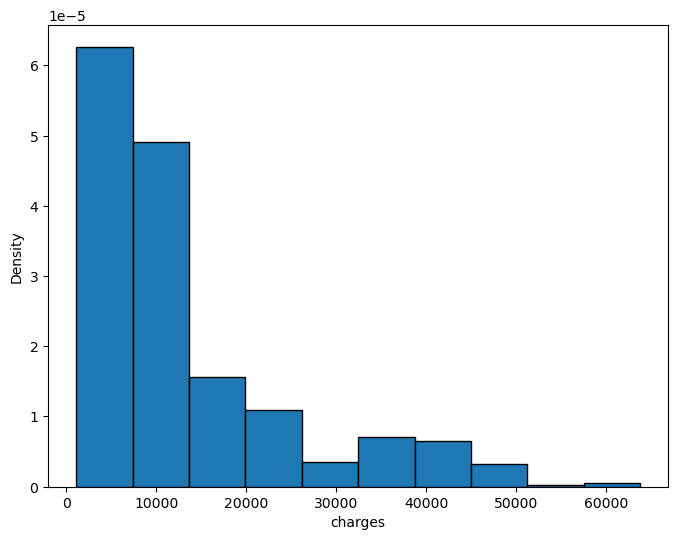

Columns with outlier percentage :-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  ColumnName  OutlierPercentage
0    charges          10.186916
1        bmi           0.373832


age,sex,bmi,children,smoker,region,charges
34,male,34.21,0,no,southeast,3935.1799
38,male,29.26,2,no,northwest,6457.8434
38,male,28.025,1,no,northeast,6067.12675
32,female,17.765,2,yes,northwest,32734.1863
19,female,21.7,0,yes,southwest,13844.506
19,male,20.615,2,no,northwest,2803.69785
49,female,31.9,5,no,southwest,11552.904
49,female,27.17,0,no,southeast,8601.3293
61,male,32.3,2,no,northwest,14119.62
61,female,21.09,0,no,northwest,13415.0381


Remaining Rows in the data: 1069                                                        
Remaining Columns in the data: 7


Analysis indicates all categorical columns are significant. No action Needed.           


Analysis Completed. Dataset does not contain any feature related to dates. No action needed.


Analysis Completed. No Missing Values Detected.                                          


Analysis completed. No imputation required.                                              


['sex', 'smoker', 'region']


age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,region_3,charges,id
49,1,0,22.61,1,1,0,0,1,0,0,9566.9909,125
49,1,0,27.1,1,1,0,0,0,0,1,26140.3603,77
49,1,0,23.18,2,1,0,0,1,0,0,10156.7832,149
49,0,1,22.515,0,1,0,1,0,0,0,8688.85885,181
49,0,1,32.3,3,1,0,0,1,0,0,10269.46,197
49,0,1,37.51,2,1,0,0,0,1,0,9304.7019,205
49,0,1,25.84,2,0,1,0,1,0,0,23807.2406,61
49,1,0,27.17,0,1,0,0,0,1,0,8601.3293,21
49,1,0,41.47,4,1,0,0,0,1,0,10977.2063,85
49,1,0,23.845,3,0,1,1,0,0,0,24106.91255,101


Columns with outlier percentage :-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  ColumnName  OutlierPercentage
0    charges          10.196445
1        bmi           0.374181


['bmi']


age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,region_3,charges,id
19,1,0,25.745,1,1,0,0,1,0,0,2710.82855,179
19,1,0,36.575,0,1,0,0,1,0,0,2136.88225,147
19,0,1,30.59,0,1,0,0,1,0,0,1639.5631,203
19,0,1,27.265,2,1,0,0,1,0,0,22493.65964,115
19,0,1,20.9,1,1,0,0,0,0,1,1832.094,67
19,1,0,24.7,0,1,0,0,0,0,1,1737.376,227
19,1,0,23.4,2,1,0,0,0,0,1,2913.569,395
19,0,1,22.61,0,1,0,0,1,0,0,1628.4709,235
19,1,0,24.605,1,1,0,0,1,0,0,2709.24395,291
19,0,1,27.6,0,1,0,0,0,0,1,1252.407,219


['smoker_1', 'region_2', 'children', 'smoker_0', 'age', 'bmi']


['children', 'age', 'bmi']


smoker_1,region_2,charges,smoker_0,id,children,age,bmi
0,0,6496.886,1,10,-0.08381617024358608,0.044568281460531003,-0.5414541776425332
0,0,6457.8434,1,12,0.7504288887229488,-0.09904811719443332,-0.23548651534936024
0,0,11552.904,1,13,3.2531640656225536,0.6908420754078705,0.19879016661514223
0,0,14119.62,1,14,0.7504288887229488,1.5525404673376564,0.26458966388249094
0,0,2904.088,1,16,-0.08381617024358608,-0.9607465091242193,-0.11375744540476496
1,1,18972.495,0,17,0.7504288887229488,-0.38628091450436197,-0.8869015382961148
1,0,32734.1863,0,15,0.7504288887229488,-0.5298973131593263,-2.1263995680698002
1,0,13844.506,0,11,-0.9180612292101209,-1.4634039044165945,-1.4790970137022554
0,1,3935.1799,1,9,-0.9180612292101209,-0.38628091450436197,0.5787822633340827
0,0,2897.3235,1,8,-0.9180612292101209,-0.9607465091242193,-0.20423175414736985


['smoker_1', 'region_2', 'sex_1', 'children', 'region_3', 'region_1', 'sex_0', 'smoker_0', 'region_0', 'age', 'bmi']


['r_children', 'r_age', 'r_bmi']


r_region_2,r_smoker_1,r_sex_1,r_smoker_0,r_region_0,charges,r_sex_0,r_region_1,id,r_region_3,r_children,r_age,r_bmi
0,0,0,1,0,6496.886,1,0,10,1,-0.08381617024358608,0.044568281460531003,-0.5414541776425332
0,0,1,1,0,6457.8434,0,1,12,0,0.7504288887229488,-0.09904811719443332,-0.23548651534936024
0,0,0,1,0,11552.904,1,0,13,1,3.2531640656225536,0.6908420754078705,0.19879016661514223
0,0,1,1,0,14119.62,0,1,14,0,0.7504288887229488,1.5525404673376564,0.26458966388249094
0,0,1,1,0,2904.088,0,0,16,1,-0.08381617024358608,-0.9607465091242193,-0.11375744540476496
1,1,1,0,0,18972.495,0,0,17,0,0.7504288887229488,-0.38628091450436197,-0.8869015382961148
0,1,0,0,0,32734.1863,1,1,15,0,0.7504288887229488,-0.5298973131593263,-2.1263995680698002
0,1,0,0,0,13844.506,1,0,11,1,-0.9180612292101209,-1.4634039044165945,-1.4790970137022554
1,0,1,1,0,3935.1799,0,0,9,0,-0.9180612292101209,-0.38628091450436197,0.5787822633340827
0,0,1,1,1,2897.3235,0,0,8,0,-0.9180612292101209,-0.9607465091242193,-0.20423175414736985


['age', 'bmi', 'children']


smoker_1,region_2,sex_1,region_0,sex_0,smoker_0,region_1,charges,region_3,id,age,bmi,children
0,0,1,0,0,1,0,1252.407,1,219,-1.463403904416595,-0.5085544290088584,-0.9180612292101222
0,0,0,0,1,1,0,3410.324,1,152,-0.9607465091242197,1.926026969883052,-0.0838161702435862
1,0,0,1,1,0,0,14455.64405,0,160,-0.9607465091242197,-2.220163851675773,0.7504288887229499
0,0,1,0,0,1,0,7196.867,1,42,0.044568281460531024,0.7580858933876081,1.584673947689486
0,1,1,0,0,1,0,4686.3887,0,39,-0.5298973131593265,2.6054067791684306,0.7504288887229499
0,0,1,0,0,1,1,4454.40265,0,103,-0.5298973131593265,-0.469897224364291,-0.0838161702435862
0,1,0,0,1,1,0,5400.9805,0,68,-0.09904811719443336,1.5559047977542142,-0.9180612292101222
0,0,0,1,1,1,0,7144.86265,0,52,-0.09904811719443336,-0.469897224364291,0.7504288887229499
0,0,0,1,1,1,0,13616.3586,0,38,1.552540467337657,-1.423167441025009,-0.9180612292101222
0,0,0,1,1,1,0,13635.6379,0,126,1.552540467337657,0.8584301267203152,-0.9180612292101222


['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7']


response_column : charges                                                                                                                             
name : decision_forest
tree_type : Regression
min_impurity : (0.0, 0.1, 0.2)
max_depth : (5, 6, 8, 10)
min_node_size : (1, 2, 3)
num_trees : (-1, 20, 30)
seed : 42
Total number of models for decision_forest : 108
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

response_column : charges
name : xgboost
model_type : Regression
column_sampling : (1, 0.6)
min_impurity : (0.0, 0.1, 0.2)
lambda1 : (0.01, 0.1, 1, 10)
shrinkage_factor : (0.5, 0.1, 0.3)
max_depth : (5, 6, 8, 10)
min_node_size : (1, 2, 3)
iter_num : (10, 20, 30)
seed : 42
Total number of models for xgboost : 2592
-----------------------------------------------------------------------------------------------------------------------

,RANK,MODEL_ID,FEATURE_SELECTION,MAE,MSE,MSLE,MAPE,MPE,RMSE,RMSLE,ME,R2,EV,MPD,MGD,ADJUSTED_R2
0,1,DECISIONFOREST_3,lasso,3204.701352,2.394295e+07,0.199091,34.994715,-21.577959,4893.153590,0.446197,17474.243217,0.807572,0.807588,1969.472143,0.222008,0.806481
1,2,XGBOOST_3,lasso,2673.385865,2.444487e+07,0.181988,23.594700,-6.541959,4944.174856,0.426601,17671.244446,0.803538,0.807378,2087.162683,0.257690,0.802424
2,3,XGBOOST_0,lasso,2673.385865,2.444487e+07,0.181988,23.594700,-6.541959,4944.174856,0.426601,17671.244446,0.803538,0.807378,2087.162683,0.257690,0.802424
3,4,XGBOOST_1,rfe,2668.422255,2.532534e+07,0.199505,22.181357,-4.631161,5032.428554,0.446659,19249.934581,0.796462,0.801755,2307.962874,0.336576,0.794336
4,5,KNN_9,lasso,2974.159143,2.607148e+07,0.199978,27.358116,-9.626668,5106.024328,0.447189,19529.044003,0.790465,0.793756,2222.172457,0.280939,0.789277
5,6,KNN_0,lasso,3087.714859,2.962272e+07,0.229071,28.431382,-8.798467,5442.675972,0.478614,19826.448998,0.761924,0.765923,2537.747478,0.330693,0.760574
6,7,DECISIONFOREST_1,rfe,3083.396493,3.107220e+07,0.212347,26.262703,-7.555852,5574.244104,0.460811,21811.492299,0.750275,0.753803,2535.565179,0.334727,0.747666
7,8,DECISIONFOREST_0,lasso,3161.345176,3.283612e+07,0.227639,27.882445,-9.461145,5730.280634,0.477116,21811.492299,0.736098,0.738584,2672.358087,0.356194,0.734602
8,9,XGBOOST_2,pca,3501.320112,3.491305e+07,0.277218,36.237425,-17.814087,5908.726241,0.526515,19858.598415,0.719406,0.719518,2957.143306,0.372699,0.717280
9,10,KNN_8,pca,3473.042257,3.718392e+07,0.247896,27.244913,-4.455118,6097.861885,0.497892,28910.202216,0.701155,0.715915,3050.637886,0.395608,0.698891


In [16]:
# Fitting train data
aml.fit(insurance_df_train, insurance_df_train.charges)

## <b><span style='color:#F1A424'>| 3.</span> Leaderboard : </b>

In [17]:
# Fetching Leaderboard
aml.leaderboard()

,RANK,MODEL_ID,FEATURE_SELECTION,MAE,MSE,MSLE,MAPE,MPE,RMSE,RMSLE,ME,R2,EV,MPD,MGD,ADJUSTED_R2
0,1,DECISIONFOREST_3,lasso,3204.701352,2.394295e+07,0.199091,34.994715,-21.577959,4893.153590,0.446197,17474.243217,0.807572,0.807588,1969.472143,0.222008,0.806481
1,2,XGBOOST_3,lasso,2673.385865,2.444487e+07,0.181988,23.594700,-6.541959,4944.174856,0.426601,17671.244446,0.803538,0.807378,2087.162683,0.257690,0.802424
2,3,XGBOOST_0,lasso,2673.385865,2.444487e+07,0.181988,23.594700,-6.541959,4944.174856,0.426601,17671.244446,0.803538,0.807378,2087.162683,0.257690,0.802424
3,4,XGBOOST_1,rfe,2668.422255,2.532534e+07,0.199505,22.181357,-4.631161,5032.428554,0.446659,19249.934581,0.796462,0.801755,2307.962874,0.336576,0.794336
4,5,KNN_9,lasso,2974.159143,2.607148e+07,0.199978,27.358116,-9.626668,5106.024328,0.447189,19529.044003,0.790465,0.793756,2222.172457,0.280939,0.789277
5,6,KNN_0,lasso,3087.714859,2.962272e+07,0.229071,28.431382,-8.798467,5442.675972,0.478614,19826.448998,0.761924,0.765923,2537.747478,0.330693,0.760574
6,7,DECISIONFOREST_1,rfe,3083.396493,3.107220e+07,0.212347,26.262703,-7.555852,5574.244104,0.460811,21811.492299,0.750275,0.753803,2535.565179,0.334727,0.747666
7,8,DECISIONFOREST_0,lasso,3161.345176,3.283612e+07,0.227639,27.882445,-9.461145,5730.280634,0.477116,21811.492299,0.736098,0.738584,2672.358087,0.356194,0.734602
8,9,XGBOOST_2,pca,3501.320112,3.491305e+07,0.277218,36.237425,-17.814087,5908.726241,0.526515,19858.598415,0.719406,0.719518,2957.143306,0.372699,0.717280
9,10,KNN_8,pca,3473.042257,3.718392e+07,0.247896,27.244913,-4.455118,6097.861885,0.497892,28910.202216,0.701155,0.715915,3050.637886,0.395608,0.698891


## <b><span style='color:#F1A424'>| 4.</span> Best Performing Model : </b>

In [18]:
# Fetching best performing model for dataset
aml.leader()

,RANK,MODEL_ID,FEATURE_SELECTION,MAE,MSE,MSLE,MAPE,MPE,RMSE,RMSLE,ME,R2,EV,MPD,MGD,ADJUSTED_R2
0,1,DECISIONFOREST_3,lasso,3204.701352,2.394295e+07,0.199091,34.994715,-21.577959,4893.15359,0.446197,17474.243217,0.807572,0.807588,1969.472143,0.222008,0.806481


## <b><span style='color:#F1A424'>| 5.</span> Get Hyperparameter for Trained Model : </b>

In [19]:
aml.model_hyperparameters(rank=2)

{'response_column': 'charges',
 'name': 'xgboost',
 'model_type': 'Regression',
 'column_sampling': 1,
 'min_impurity': 0.0,
 'lambda1': 0.01,
 'shrinkage_factor': 0.5,
 'max_depth': 5,
 'min_node_size': 1,
 'iter_num': 20,
 'seed': 42,
 'persist': False}

In [20]:
aml.model_hyperparameters(rank=4)

{'response_column': 'charges',
 'name': 'xgboost',
 'model_type': 'Regression',
 'column_sampling': 1,
 'min_impurity': 0.0,
 'lambda1': 0.01,
 'shrinkage_factor': 0.5,
 'max_depth': 5,
 'min_node_size': 1,
 'iter_num': 10,
 'seed': 42,
 'persist': False}

## <b><span style='color:#F1A424'>| 6.</span> Generate Prediction and Performance Metrics : </b>

In [21]:
# Generating prediction on test data
prediction = aml.predict(insurance_df_test)

Data Transformation started ...


age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,region_3,charges,id
32,1,0,24.6,0,0,1,0,0,0,1,17496.306,47
32,0,1,33.63,1,0,1,1,0,0,0,37607.5277,23
32,1,0,29.8,2,1,0,0,0,0,1,5152.134,15
32,0,1,31.5,1,1,0,0,0,0,1,4076.497,31
51,1,0,25.8,1,1,0,0,0,0,1,9861.025,87
51,0,1,37.0,0,1,0,0,0,0,1,8798.593,79
51,1,0,39.5,1,1,0,0,0,0,1,9880.068,95
32,0,1,28.12,4,0,1,0,1,0,0,21472.4788,63
32,1,0,28.93,0,1,0,0,0,1,0,3972.9247,39
32,0,1,30.8,3,1,0,0,0,0,1,5253.524,55


id,smoker_1,region_2,children,smoker_0,age,bmi,charges
306,1,1,2,0,52,41.8,47269.854
65,1,1,2,0,64,36.96,49577.6624
45,1,1,1,0,41,35.75,40273.6455
109,1,0,1,0,50,27.6,24520.264
181,1,0,2,0,48,40.565,45702.0223
149,1,1,3,0,48,25.85,24180.9335
17,0,0,1,1,34,27.5,5003.853
33,0,0,1,1,64,24.7,30166.6182
113,0,0,0,1,33,26.695,4571.4131
105,0,0,1,1,33,22.135,5354.0746


smoker_1,region_2,charges,smoker_0,id,children,age,bmi
0,0,4571.4131,1,113,-0.9180612292101209,-0.45808911383184414,-0.6574257915762355
0,1,3704.3545,1,121,-0.9180612292101209,-0.45808911383184414,-0.07263275961267188
0,0,4766.022,1,89,-0.08381617024358608,-0.45808911383184414,-2.005492991841047
0,1,11326.7149,1,81,-0.08381617024358608,-0.45808911383184414,1.9358968944731545
0,0,6389.3778,1,26,-0.08381617024358608,0.044568281460531003,-0.7199353139802168
0,0,6986.697,1,18,0.7504288887229488,0.044568281460531003,0.26458966388249094
1,1,35595.5898,0,130,1.5846739476894836,-1.247979306434148,0.054031272626974755
1,0,39983.4259,0,282,1.5846739476894836,-0.3144727151768798,0.5615098953014029
1,1,47269.854,0,306,0.7504288887229488,0.906266673390317,1.8273277239820283
1,0,29330.9832,0,57,-0.9180612292101209,1.767965065320103,-0.6261710303742445


id,smoker_1,region_2,sex_1,children,region_3,region_1,sex_0,smoker_0,region_0,age,bmi,charges
306,1,1,1,2,0,0,0,0,0,52,41.8,47269.854
65,1,1,1,2,0,0,0,0,0,64,36.96,49577.6624
45,1,1,1,1,0,0,0,0,0,41,35.75,40273.6455
109,1,0,0,1,1,0,1,0,0,50,27.6,24520.264
181,1,0,1,2,0,1,0,0,0,48,40.565,45702.0223
149,1,1,0,3,0,0,1,0,0,48,25.85,24180.9335
17,0,0,0,1,1,0,1,1,0,34,27.5,5003.853
33,0,0,1,1,0,1,0,1,0,64,24.7,30166.6182
113,0,0,0,0,0,1,1,1,0,33,26.695,4571.4131
105,0,0,0,1,0,0,1,1,1,33,22.135,5354.0746


r_region_2,r_smoker_1,r_region_3,r_smoker_0,r_region_0,charges,r_sex_0,r_region_1,id,r_sex_1,r_children,r_age,r_bmi
1,1,0,0,0,47269.854,0,0,306,1,0.7504288887229488,0.906266673390317,1.8273277239820283
1,1,0,0,0,49577.6624,0,0,65,1,0.7504288887229488,1.767965065320103,1.0311538070471067
1,1,0,0,0,40273.6455,0,0,45,1,-0.08381617024358608,0.11637648078801317,0.832110327813376
0,1,1,0,0,24520.264,1,0,109,0,-0.08381617024358608,0.7626502747353526,-0.5085544290088584
0,1,0,0,0,45702.0223,0,1,181,1,0.7504288887229488,0.6190338760803883,1.6241717761690884
1,1,0,0,0,24180.9335,1,0,149,0,1.5846739476894836,0.6190338760803883,-0.79642722955351
0,0,1,1,0,5003.853,1,0,17,0,-0.08381617024358608,-0.38628091450436197,-0.5250043033256958
0,0,0,1,0,30166.6182,0,1,33,1,-0.08381617024358608,1.767965065320103,-0.9856007841971385
0,0,0,1,0,4571.4131,1,1,113,0,-0.9180612292101209,-0.45808911383184414,-0.6574257915762355
0,0,0,1,1,5354.0746,1,0,105,0,-0.08381617024358608,-0.45808911383184414,-1.4075400604240131


smoker_1,region_2,sex_1,region_3,sex_0,charges,region_1,region_0,smoker_0,id,age,bmi,children
1,1,1,0,0,47269.854,0,0,0,306,0.9062666733903173,1.8273277239820285,0.7504288887229499
1,1,1,0,0,49577.6624,0,0,0,65,1.7679650653201036,1.0311538070471067,0.7504288887229499
1,1,1,0,0,40273.6455,0,0,0,45,0.11637648078801321,0.8321103278133761,-0.0838161702435862
1,0,0,1,1,24520.264,0,0,0,109,0.762650274735353,-0.5085544290088584,-0.0838161702435862
1,0,1,0,0,45702.0223,1,0,0,181,0.6190338760803885,1.6241717761690886,0.7504288887229499
1,1,0,0,1,24180.9335,0,0,0,149,0.6190338760803885,-0.7964272295535101,1.584673947689486
0,0,0,1,1,5003.853,0,0,1,17,-0.38628091450436214,-0.5250043033256959,-0.0838161702435862
0,0,1,0,0,30166.6182,1,0,1,33,1.7679650653201036,-0.9856007841971386,-0.0838161702435862
0,0,0,0,1,4571.4131,1,0,1,113,-0.4580891138318443,-0.6574257915762356,-0.9180612292101222
0,0,0,0,1,5354.0746,0,1,1,105,-0.4580891138318443,-1.4075400604240134,-0.0838161702435862


C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,id,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,charges
0,130,-0.252990,1.417209,1.414906,0.675167,1.329404,0.053937,-0.349576,-0.343106,35595.5898
1,17,-0.656678,0.110070,-0.087713,0.709039,-0.301600,-0.272412,0.605727,-0.570700,5003.8530
2,282,0.571768,1.296994,0.828371,0.691452,1.048384,0.828952,0.479972,0.506736,39983.4259
3,33,0.430890,0.259988,-1.988143,-0.719704,-0.367754,0.738025,-0.095750,0.120149,30166.6182
4,306,2.153002,-0.035468,0.736875,-0.747028,1.172403,0.078915,-0.214235,-0.105841,47269.8540
5,113,-1.098217,-0.590538,-0.343590,0.678287,-0.282397,0.751133,0.054009,0.212897,4571.4131
6,57,0.327719,-0.685398,-1.979997,0.441546,1.160000,0.792430,0.354321,0.300797,29330.9832
7,105,-1.354202,0.449973,-0.609105,0.699356,-0.176754,-0.615939,-0.289247,0.416939,5354.0746
8,65,2.164796,0.212920,-0.393131,-0.795149,1.231702,0.058982,-0.323986,-0.245106,49577.6624
9,121,-0.515638,-0.846264,0.256019,-0.709105,-0.185676,-0.003566,-0.716428,-0.480143,3704.3545


Data Transformation completed.⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿｜ 100% - 10/10           

Following model is being picked for evaluation:
Model ID : DECISIONFOREST_3 
Feature Selection Method : lasso

Prediction : 
    id    prediction  confidence_lower  confidence_upper     charges
0  306  42456.455117      39594.812820      45318.097413  47269.8540
1   65  43821.715127      41747.441250      45895.989004  49577.6624
2   45  41275.445319      36581.760211      45969.130427  40273.6455
3  109  24875.286633      19805.671251      29944.902016  24520.2640
4  181  42222.802902      38018.921064      46426.684741  45702.0223
5  149  24303.288351      20536.908519      28069.668182  24180.9335
6   17   6103.782673       4619.807335       7587.758011   5003.8530
7   33  18672.879362      14075.065843      23270.692882  30166.6182
8  113   4641.218062       4250.189483       5032.246641   4571.4131
9  105   5952.451557       3690.094012       8214.809102   5354.0746


In [22]:
# Printing prediction
prediction.head()

id,prediction,confidence_lower,confidence_upper,charges
10,42032.78608416667,37189.83443313146,46875.73773520188,39125.3322
12,6434.452968767551,5284.29805358905,7584.607883946052,5397.6167
13,9153.829273261365,8557.430474860961,9750.228071661768,9290.1395
14,17023.53963655303,12626.011226854382,21421.068046251676,13041.921
16,5729.26219002381,3672.9437733456202,7785.580606702,3877.3043
17,6103.782672803571,4619.807334886606,7587.758010720535,5003.853
15,5762.1926175238095,3959.7609628114706,7564.6242722361485,5152.134
11,5097.544971856836,2547.738434366539,7647.351509347133,1263.249
9,8495.457274636905,6139.749056501987,10851.165492771823,5124.1887
8,37649.408110000004,33941.768350144586,41357.04786985542,36085.219


In [23]:
# Fetching evaluation on test data
performance_metrics = aml.evaluate(insurance_df_test)


Skipping data transformation as data is already transformed.

Following model is being picked for evaluation:
Model ID : DECISIONFOREST_3 
Feature Selection Method : lasso

Performance Metrics : 
          MAE           MSE      MSLE      MAPE        MPE         RMSE    RMSLE            ME        R2        EV          MPD      MGD
0  3100.62896  2.398601e+07  0.241483  43.13417 -32.224945  4897.551806  0.49141  21469.649859  0.850378  0.850813  1992.934241  0.25098


In [24]:
performance_metrics

MAE,MSE,MSLE,MAPE,MPE,RMSE,RMSLE,ME,R2,EV,MPD,MGD
3100.628960023781,23986013.693712488,0.24148334642312236,43.13416973364617,-32.22494535199111,4897.551806128496,0.4914095506022674,21469.64985903602,0.8503783196868526,0.850812769850841,1992.9342408016396,0.2509798215570872


## <b><span style='color:#F1A424'>| 7.</span> Deploy and Load Models : </b>

### <b><span style='color:#F1A424'>| 7.1. </span> Deploy models : </b>

In [25]:
aml.deploy(table_name='ins_range_models', ranks=range(4,7))

Model Deployment Completed Successfully.


### <b><span style='color:#F1A424'>| 7.2. </span> Load models : </b>

In [26]:
# Loading models

models_1 = aml.load('ins_range_models')

In [27]:
models_1

,RANK,MODEL_ID,FEATURE_SELECTION,MAE,MSE,MSLE,MAPE,MPE,RMSE,RMSLE,ME,R2,EV,MPD,MGD,DATA_TABLE,ADJUSTED_R2
0,1,XGBOOST_1,rfe,2668.422255,2.532534e+07,0.199505,22.181357,-4.631161,5032.428554,0.446659,19249.934581,0.796462,0.801755,2307.962874,0.336576,ml__charges_rfe_1723404560060678,0.794336
1,2,KNN_9,lasso,2974.159143,2.607148e+07,0.199978,27.358116,-9.626668,5106.024328,0.447189,19529.044003,0.790465,0.793756,2222.172457,0.280939,ml__charges_lasso_1723400611097538,0.789277
2,3,KNN_0,lasso,3087.714859,2.962272e+07,0.229071,28.431382,-8.798467,5442.675972,0.478614,19826.448998,0.761924,0.765923,2537.747478,0.330693,ml__charges_lasso_1723400611097538,0.760574
3,4,DECISIONFOREST_1,rfe,3083.396493,3.107220e+07,0.212347,26.262703,-7.555852,5574.244104,0.460811,21811.492299,0.750275,0.753803,2535.565179,0.334727,ml__charges_rfe_1723404560060678,0.747666


### <b><span style='color:#F1A424'>| 7.3. </span> Predict and evaluate using loaded models : </b>

In [30]:
prediction = aml.predict(insurance_df_test, use_loaded_models=True)

Generating prediction using:
Model Name: XGBOOST
Feature Selection: rfe


In [31]:
prediction.head()

id,Prediction,Confidence_Lower,Confidence_upper,charges
10,38449.922177,38449.922177,38449.922177,39125.3322
12,6185.94562,6185.94562,6185.94562,5397.6167
13,10702.997376,10702.997376,10702.997376,9290.1395
14,13888.638177999997,13888.638177999997,13888.638177999997,13041.921
16,5109.670029,5109.670029,5109.670029,3877.3043
17,5262.807331999999,5262.807331999999,5262.807331999999,5003.853
15,7233.995158999999,7233.995158999999,7233.995158999999,5152.134
11,1902.108858,1902.108858,1902.108858,1263.249
9,6028.903419,6028.903419,6028.903419,5124.1887
8,34441.198294,34441.198294,34441.198294,36085.219


In [32]:
performance_metrics = aml.evaluate(insurance_df_test, use_loaded_models=True)

Generating performance metrics using:
Model Name: XGBOOST
Feature Selection: rfe


In [33]:
performance_metrics


############ result Output ############

           MAE           MSE      MSLE       MAPE        MPE         RMSE     RMSLE            ME        R2        EV  MPD  MGD
0  2574.275102  2.588786e+07  0.237163  31.468026 -17.706257  5088.011741  0.486994  27078.748073  0.838515  0.838685  NaN  NaN


In [34]:
remove_context()

True